<a href="https://colab.research.google.com/github/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/11_cnn_pytorch/08_segnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08：SegNet

---

## 目的
セマンティックセグメンテーションとは何か理解する．\
SegNetの構造を理解する．\
SegNetを用いてARCDatsetでセグメンテーションを行う．

## セマンティックセグメンテーション

セマンティックセグメンテーションは,
画像内のオブジェクトをピクセル単位でクラス分類を行うタスクです．\
複数の物体を認識することができ，物体位置や形状も認識することができます．
自動運転や医療画像などの分野で使用されています．

<img src="http://drive.google.com/uc?export=view&id=1Y995doYMR0jW-knUB5NCGN2SFTxnTECh" width = 30%>


<img src="http://drive.google.com/uc?export=view&id=1lTrHT21WBF-ylkArTB3fp0s6815jDSZB" width = 30%>


## SegNet

セマンティックセグメンテーションのネットワークはすべての層が畳み込み層となっていて，最終層ではクラス分のチャンネル数を出力します．\
<img src="http://drive.google.com/uc?export=view&id=1ZZoVHg8HtBYDizhtfCZ6iNCR_tEEkSsi" width = 70%>

### エンコーダデコーダ構造
エンコーダでは，入力画像を畳み込みとpoolingを繰り返すことで，圧縮していき特徴マップを抽出する役割をしています．
デコーダでは，unpoolingと畳み込み層を繰り返して，圧縮した特徴マップを元のサイズに戻していきます． エンコーダデコーダ構造にすることで，省メモリ化といった効果があります．


## Pooling indices
プーリング処理は，繰り返しおこなうことで局所的な特徴が欠落してしまいます． そこでSegNetでは，エンコーダでMaxPoolingを行ったときに最大値の位置情報を記録します，そして，unpoolingするときにその位置情報を使ってピクセルを戻していきます．この時，記録されていない位置には0が入ります．\
<img src="http://drive.google.com/uc?export=view&id=1uYN4W0kZK32x987IptgSlQmWYYkk5qdd" width = 70%>

必要なモジュールのインポート

In [ ]:
import os
from PIL import Image, ImageOps, ImageFilter
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms.functional import normalize
import sys
import glob
import numbers
import random
import matplotlib.pyplot as plt
import torchsummary
import cv2

GPUの確認

In [ ]:
use_cuda = torch.cuda.is_available()
print('Use CUDA:', use_cuda)

Use CUDA: True


GPUの確認です．

In [ ]:
!nvidia-smi

Thu Oct  1 14:50:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    34W / 149W |     11MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# データセットの用意
セマンティックセグメンテーションは入力画像とラベル画像を用意する必要があります\
そのため，専用のDatasetクラスやデータ拡張クラスを用意しなければなりません．\
今回は，ARCDatsetを使用します．


## データ拡張
セマンティックセグメンテーションでデータ拡張する場合は，入力画像とラベル画像に同じ処理を行なう必要があります．\
Pytorchのデータ拡張は，入力画像とラベル画像を同時に行えないため専用のものを用意します．\
今回は切り抜き，正規化の処理をPILという画像処理ライブラリを使い実装します．

In [ ]:
class Normalize(object):
    def __init__(self, mean=(0., 0., 0.), std=(1., 1., 1.)):
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        img = sample['image']
        mask = sample['label']
        img = np.array(img).astype(np.float32)
        mask = np.array(mask).astype(np.float32)
        img /= 255.0
        img -= self.mean
        img /= self.std
       
        return {'image': img,
                'label': mask}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __init__(self):
        self.to_tensor = transforms.ToTensor()

    def __call__(self, sample):
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        img = sample['image']
        mask = sample['label']
        #print(mask.shape)
        img = np.array(img).astype(np.float32).transpose((2, 0, 1))
        #img = self.to_tensor(img)
        mask = np.array(mask).astype(np.float32)

        img = torch.from_numpy(img).float()
        mask = torch.from_numpy(mask).float()

        return {'image': img,
                'label': mask}



class RandomCrop(object):
    def __init__(self, size, padding=0):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size # h, w
        self.padding = padding

    def __call__(self, sample):
        img, mask = sample['image'], sample['label']

        if self.padding > 0:
            img = ImageOps.expand(img, border=self.padding, fill=0)
            mask = ImageOps.expand(mask, border=self.padding, fill=255)

        assert img.size == mask.size
        w, h = img.size
        th, tw = self.size # target size
        if w == tw and h == th:
            return {'image': img,
                    'label': mask}
        if w < tw or h < th:
            img = img.resize((tw, th), Image.BILINEAR)
            mask = mask.resize((tw, th), Image.NEAREST)
            return {'image': img,
                    'label': mask}

        x1 = random.randint(0, w - tw)
        y1 = random.randint(0, h - th)
        img = img.crop((x1, y1, x1 + tw, y1 + th))
        mask = mask.crop((x1, y1, x1 + tw, y1 + th))

        return {'image': img,
                'label': mask}


## データセットクラス
専用のDatasetクラスを用意します．\
Datsetクラスを作成するときは，torch.utils.data.Datasetを継承してオーバーライドします．\



In [ ]:
#ラベル画像がRGB画像となっているので0～41の値に変換します
class_color = np.array([
           [  0,   0,   0],
           [ 85,   0,   0],
           [170,   0,   0],
           [255,   0,   0],
           [  0,  85,   0],
           [ 85,  85,   0],
           [170,  85,   0],
           [255,  85,   0],
           [  0, 170,   0],
           [ 85, 170,   0],
           [170, 170,   0],
           [255, 170,   0],
           [  0, 255,   0],
           [ 85, 255,   0],
           [170, 255,   0],
           [255, 255,   0],
           [  0,   0,  85],
           [ 85,   0,  85],
           [170,   0,  85],
           [255,   0,  85],
           [  0,  85,  85],
           [ 85,  85,  85],
           [170,  85,  85],
           [255,  85,  85],
           [  0, 170,  85],
           [ 85, 170,  85],
           [170, 170,  85],
           [255, 170,  85],
           [  0, 255,  85],
           [ 85, 255,  85],
           [170, 255,  85],
           [255, 255,  85],
           [  0,   0, 170],
           [ 85,   0, 170],
           [170,   0, 170],
           [255,   0, 170],
           [  0,  85, 170],
           [ 85,  85, 170],
           [170,  85, 170],
           [255,  85, 170],
           [  0, 170, 170]])

class_color = class_color[:, ::-1]
print(class_color.shape[0])

def convertGray(img):
    img = np.array(img, dtype=np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    for i in range(0, class_color.shape[0]):
        #print(class_color[i])
        img[np.where((img == class_color[i]).all(axis=2))] = [i, i, i]

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img=Image.fromarray(img)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img


def image_basename(filename):
    return os.path.basename(os.path.splitext(filename)[0])

def is_image(filename):
    return filename.endswith('.png')

def is_label(filename):
    return filename.endswith(".png")

def is_label_sip(filename):
    return filename.endswith(".png")

def image_path(root, basename, extension):
    return os.path.join(root, f'{basename}{extension}')

class MYDataset(Dataset):
    
    def __init__(self, split, transform):

        #self._base_dir = '/content/drive/My Drive/dataset/'
        self._base_dir = '/content/drive/My Drive/ARCdataset_png/'
        
        self.split = split
        self.images_root = os.path.join(self._base_dir, split, 'rgb/')
        self.labels_root = os.path.join(self._base_dir, split, 'segmentation/')
        
        self.filenames = [image_basename(f)
            for f in os.listdir(self.images_root) if is_image(f)]
        self.filenames.sort()

        self.filenamesGt = [image_basename(f)
            for f in os.listdir(self.labels_root) if is_label_sip(f)]
        self.filenamesGt.sort()

        self.transform = transform
    
    def __len__(self):
        return len(self.filenames)


    def __getitem__(self, index):
         # 1. 画像読み込み
        image_file_path = self.filenames[index]+ '.png'
        #print( image_file_path)
        image_file_path = os.path.join(self._base_dir, self.split, 'rgb/', image_file_path)
        img = Image.open(image_file_path).convert('RGB')

        # 2. アノテーション画像読み込み
        label_file_path = self.filenamesGt[index]+ '.png'
        label_file_path = os.path.join(self._base_dir, self.split, 'segmentation/', label_file_path)
        label_class_img = Image.open(label_file_path).convert('RGB')
        #print(label_class_img.size)
        label_class_img =  convertGray(label_class_img)
      
        sample = {'image': img, 'label': label_class_img}

        # 3. データ拡張を実施
        return self.transform(sample)




41


## データローダの作成
`transforms.Compose`を使い，使用するデータ拡張を設定します．先ほど作成したリサイズ，クロップ，画像の正規化のクラスを使用します．\
次にMYDatasetクラスには学習データか検証データどちらを使用するかとデータ拡張の設定を与えます．\
作成したMYDatasetクラスは`DataLoader`に与えます．
ミニバッチは6とします．


In [ ]:
# データ拡張を設定
transform = transforms.Compose([
    RandomCrop((224,224)), #224,224で切り抜き
    Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ToTensor(),
])

test_transform = transforms.Compose([
    Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ToTensor(),
])

# データセットの作成
train_dataset = MYDataset(split='train', transform=transform)
val_dataset = MYDataset(split='val', transform=test_transform)

# データローダーの作成
batch_size =6
train_loader = DataLoader(train_dataset, batch_size=6, num_workers=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, num_workers=0, shuffle=False)



# ネットワークモデルの定義
SegNetを定義します．

エンコーダでは，畳み込み層，BatchNorm，ReLUを2，3回繰り返した後MaxPoolingを行います．Pooling後はチャンネル数を増やして最終的に512チャンネルになります．
Pooling処理は，`F.max_pool2d()`の引数を`return_indices=True`にすることで最大値を取った場所の位置情報を獲得することができます．

また，各Pooling前の特徴マップのサイズ情報も獲得しておきます


デコーダでは，まずアンプ―リング処理を行います．
その後，逆畳み込み処理，BatchNorm，ReLUを2，3回繰り返していきます．
エンコーダでは，チャンネル数を徐々に増やしていきましたが，デコーダではチャンネル数を徐々に減らしていきます．
unpooling処理では，位置情報と出力する得著マップのサイズを渡します.\
`F.max_unpool2d()`の二つ目の引数に`F.max_pool2d()`で獲得した位置情報を与え,
`output_siz`に出力する特徴マップサイズを与えます．

デコーダの最終層はクラス数のチャンネルを出力します．


In [ ]:
"""
Pytorch implementation of SegNet (https://arxiv.org/pdf/1511.00561.pdf)
"""

from __future__ import print_function
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import pprint


class SegNet(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(SegNet, self).__init__()

        self.input_channels = input_channels
        self.output_channels = output_channels

        self.num_channels = input_channels

        #self.vgg16 = models.vgg16(pretrained=True)


        # Encoder layers

        self.encoder_conv_00 = nn.Sequential(nn.Conv2d(in_channels=self.input_channels, out_channels=64, kernel_size=3, padding=1),
                                             nn.BatchNorm2d(64),
                                             nn.ReLU(inplace=True))
        
        self.encoder_conv_01 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                             nn.BatchNorm2d(64),
                                             nn.ReLU(inplace=True))
        
        self.encoder_conv_10 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                                             nn.BatchNorm2d(128),
                                             nn.ReLU(inplace=True))
        
        self.encoder_conv_11 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                             nn.BatchNorm2d(128),
                                             nn.ReLU(inplace=True))
        
        self.encoder_conv_20 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
                                             nn.BatchNorm2d(256),
                                             nn.ReLU(inplace=True))
        
        self.encoder_conv_21 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                             nn.BatchNorm2d(256),
                                             nn.ReLU(inplace=True))
        
        self.encoder_conv_22 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                             nn.BatchNorm2d(256),
                                             nn.ReLU(inplace=True))
        
        self.encoder_conv_30 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
                                             nn.BatchNorm2d(512),
                                             nn.ReLU(inplace=True))
        
        self.encoder_conv_31 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                             nn.BatchNorm2d(512),
                                             nn.ReLU(inplace=True))
        
        self.encoder_conv_32 = nn.Sequential(nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3, padding=1),
                                             nn.BatchNorm2d(512),
                                             nn.ReLU(inplace=True))
        
        self.encoder_conv_40 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                             nn.BatchNorm2d(512),
                                             nn.ReLU(inplace=True))
        
        self.encoder_conv_41 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                             nn.BatchNorm2d(512),
                                             nn.ReLU(inplace=True))
        
        self.encoder_conv_42 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                             nn.BatchNorm2d(512),
                                             nn.ReLU(inplace=True))

        #self.init_vgg_weigts()
        # Decoder layers

        self.decoder_convtr_42 = nn.Sequential(nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                               nn.BatchNorm2d(512),
                                               nn.ReLU(inplace=True))
        
        self.decoder_convtr_41 = nn.Sequential(nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                               nn.BatchNorm2d(512),
                                               nn.ReLU(inplace=True))
        
        self.decoder_convtr_40 = nn.Sequential(nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                               nn.BatchNorm2d(512),
                                               nn.ReLU(inplace=True))
        
        self.decoder_convtr_32 = nn.Sequential(nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                               nn.BatchNorm2d(512),
                                               nn.ReLU(inplace=True))
        
        self.decoder_convtr_31 = nn.Sequential(nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                               nn.BatchNorm2d(512),
                                               nn.ReLU(inplace=True))
        
        self.decoder_convtr_30 = nn.Sequential(nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
                                               nn.BatchNorm2d(256),
                                               nn.ReLU(inplace=True))
        
        self.decoder_convtr_22 = nn.Sequential(nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                               nn.BatchNorm2d(256),
                                               nn.ReLU(inplace=True))
        
        self.decoder_convtr_21 = nn.Sequential(nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                               nn.BatchNorm2d(256),
                                               nn.ReLU(inplace=True))
        
        self.decoder_convtr_20 = nn.Sequential(nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
                                               nn.BatchNorm2d(128),
                                               nn.ReLU(inplace=True))
        
        self.decoder_convtr_11 = nn.Sequential(nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                               nn.BatchNorm2d(128),
                                               nn.ReLU(inplace=True))
        
        self.decoder_convtr_10 = nn.Sequential(nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
                                               nn.BatchNorm2d(64),
                                               nn.ReLU(inplace=True))
        
        self.decoder_convtr_01 = nn.Sequential(nn.ConvTranspose2d(in_channels=64,out_channels=64, kernel_size=3, padding=1),
                                               nn.BatchNorm2d(64),
                                               nn.ReLU(inplace=True))
        
        self.decoder_convtr_00 = nn.ConvTranspose2d(in_channels=64, out_channels=self.output_channels, kernel_size=3, padding=1)


    def forward(self, input_img):
        """
        Forward pass `input_img` through the network
        """

        # Encoder

        # Encoder Stage - 1
        dim_0 = input_img.size()
        x_00 = self.encoder_conv_00(input_img)
        x_01 = self.encoder_conv_01(x_00)
        x_0, indices_0 = F.max_pool2d(x_01, kernel_size=2, stride=2, return_indices=True)

        # Encoder Stage - 2
        dim_1 = x_0.size()
        x_10 = self.encoder_conv_10(x_0)
        x_11 = self.encoder_conv_11(x_10)
        x_1, indices_1 = F.max_pool2d(x_11, kernel_size=2, stride=2, return_indices=True)

        # Encoder Stage - 3
        dim_2 = x_1.size()
        x_20 = self.encoder_conv_20(x_1)
        x_21 = self.encoder_conv_21(x_20)
        x_22 = self.encoder_conv_22(x_21)
        x_2, indices_2 = F.max_pool2d(x_22, kernel_size=2, stride=2, return_indices=True)

        # Encoder Stage - 4
        dim_3 = x_2.size()
        x_30 = self.encoder_conv_30(x_2)
        x_31 = self.encoder_conv_31(x_30)
        x_32 = self.encoder_conv_32(x_31)
        x_3, indices_3 = F.max_pool2d(x_32, kernel_size=2, stride=2, return_indices=True)

        # Encoder Stage - 5
        dim_4 = x_3.size()
        x_40 = self.encoder_conv_40(x_3)
        x_41 = self.encoder_conv_41(x_40)
        x_42 = self.encoder_conv_42(x_41)
        x_4, indices_4 = F.max_pool2d(x_42, kernel_size=2, stride=2, return_indices=True)

        # Decoder

        dim_d = x_4.size()

        # Decoder Stage - 5
        x_4d = F.max_unpool2d(x_4, indices_4, kernel_size=2, stride=2, output_size=dim_4)
        x_42d = self.decoder_convtr_42(x_4d)
        x_41d = self.decoder_convtr_41(x_42d)
        x_40d = self.decoder_convtr_40(x_41d)
        dim_4d = x_40d.size()

        # Decoder Stage - 4
        x_3d = F.max_unpool2d(x_40d, indices_3, kernel_size=2, stride=2, output_size=dim_3)
        x_32d = self.decoder_convtr_32(x_3d)
        x_31d = self.decoder_convtr_31(x_32d)
        x_30d = self.decoder_convtr_30(x_31d)
        dim_3d = x_30d.size()

        # Decoder Stage - 3
        x_2d = F.max_unpool2d(x_30d, indices_2, kernel_size=2, stride=2, output_size=dim_2)
        x_22d = self.decoder_convtr_22(x_2d)
        x_21d = self.decoder_convtr_21(x_22d)
        x_20d = self.decoder_convtr_20(x_21d)
        dim_2d = x_20d.size()

        # Decoder Stage - 2
        x_1d = F.max_unpool2d(x_20d, indices_1, kernel_size=2, stride=2, output_size=dim_1)
        x_11d = self.decoder_convtr_11(x_1d)
        x_10d = self.decoder_convtr_10(x_11d)
        dim_1d = x_10d.size()

        # Decoder Stage - 1
        x_0d = F.max_unpool2d(x_10d, indices_0, kernel_size=2, stride=2, output_size=dim_0)
        x_01d = self.decoder_convtr_01(x_0d)
        x_00d = self.decoder_convtr_00(x_01d)
        
        return x_00d
    
 
 



# 学習

## ネットワークの設定

定義したネットワークを作成します．
`SegNet`クラスを呼び出して，ネットワークモデルを定義します．
また，GPUを使う場合（`use_cuda == True`）には，ネットワークモデルをGPUメモリ上に配置します．
これにより，GPUを用いた演算が可能となります．

学習を行う際の最適化方法としてモーメンタムSGD(モーメンタム付き確率的勾配降下法）を利用します．
また，学習率を0.01，モーメンタムを0.9として引数に与えます．

定義したネットワーク情報を`torchsummary.summary()`関数を用いて表示ます．

In [ ]:
num_class = 41
model = SegNet(input_channels=3, output_channels=num_class)
if use_cuda:
    model.cuda()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#モデルの情報を表示
torchsummary.summary(model,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
            Conv2d-7          [-1, 128, 64, 64]          73,856
       BatchNorm2d-8          [-1, 128, 64, 64]             256
              ReLU-9          [-1, 128, 64, 64]               0
           Conv2d-10          [-1, 128, 64, 64]         147,584
      BatchNorm2d-11          [-1, 128, 64, 64]             256
             ReLU-12          [-1, 128, 64, 64]               0
           Conv2d-13          [-1, 256, 32, 32]         295,168
      BatchNorm2d-14          [-1, 256,

## 評価関数の設定
mIoUとAccuracyの設定を行います．

In [ ]:
class Evaluator(object):
    def __init__(self, num_class):
        
        self.num_class = num_class
        self.confusion_matrix = np.zeros((self.num_class,)*2)

    def Pixel_Accuracy(self):
        Acc = np.diag(self.confusion_matrix).sum() / self.confusion_matrix.sum()
        return Acc

    def Mean_Intersection_over_Union(self):
        MIoU = np.diag(self.confusion_matrix) / (
                    np.sum(self.confusion_matrix, axis=1) + np.sum(self.confusion_matrix, axis=0) -
                    np.diag(self.confusion_matrix))
        MIoU = np.nanmean(MIoU)
        return MIoU

    def _generate_matrix(self, gt_image, pre_image):
        mask = (gt_image >= 0) & (gt_image < self.num_class)
        label = self.num_class * gt_image[mask].astype('int') + pre_image[mask]
        count = np.bincount(label, minlength=self.num_class**2)
        confusion_matrix = count.reshape(self.num_class, self.num_class)
        return confusion_matrix

    def add_batch(self, gt_image, pre_image):
        assert gt_image.shape == pre_image.shape
        self.confusion_matrix += self._generate_matrix(gt_image, pre_image)

    def reset(self):
        self.confusion_matrix = np.zeros((self.num_class,) * 2)


## モデルの学習


誤差関数を設定します． 使用する誤差関数はクロスエントロピー誤差です．CrossEntropyLossをcriterionとして定義します．

学習を開始します．

各更新において，学習用データと教師データをそれぞれimageとlabelとします． 学習モデルにimageを与えて画素レベルでクラスの確率を出力するyを取得します． 各クラスの確率yと教師ラベルlabelとの誤差をcriterionで算出します． また，認識精度も算出します． そして，誤差をbackward関数で逆伝播し，ネットワークの更新を行います．

segmentationの学習は時間がかかるため今回は1epochだけ学習します．

In [ ]:
import time
# ミニバッチサイズ・エポック数の設定
#batch_size = 100
epoch_num = 1

#評価関数
evaluator = Evaluator(num_class)

# 誤差関数の設定
criterion = nn.CrossEntropyLoss(ignore_index=255,reduction='mean')
if use_cuda:
    criterion.cuda()

# ネットワークを学習モードへ変更
model.train()

# 学習の実行
loss_history=[]
for epoch in range(1, epoch_num+1):
    sum_loss = 0.0
    count = 0
    evaluator.reset()


    for sample in train_loader:
        image, label = sample['image'], sample['label']    
        if use_cuda:
            image = image.cuda()
            label = label.cuda()
        y = model(image)
        loss = criterion(y, label.long())
        model.zero_grad()
        loss.backward()
        optimizer.step()
        sum_loss += loss.item()

        pred = torch.argmax(y, dim=1)
        pred = pred.data.cpu().numpy()
        target = label.cpu().numpy()      
        evaluator.add_batch(target, pred)
        
        #break

    img_size = image.size()
    loss_history.append(sum_loss)
    mIoU = evaluator.Mean_Intersection_over_Union()
    Acc = evaluator.Pixel_Accuracy()
    print(mIoU)
    print(Acc)

    print("epoch: {}, mean loss: {}, mean accuracy: {}".format(epoch, sum_loss/(len(train_loader)*batch_size), Acc))



0.04971586110207961
0.39657492448287457
epoch: 1, mean loss: 0.45554573046144586, mean accuracy: 0.39657492448287457


## 学習結果

1epoch学習した結果を確認します．



In [ ]:

# ネットワークを評価モードへ変更
model.eval()

# 評価の実行
count = 0
with torch.no_grad():
    for sample in val_loader:
        image, label = sample['image'], sample['label']

        if use_cuda:
            image = image.cuda()
           
        y = model(image)

        pred = y.data.cpu().numpy()
        #label = label.cpu().numpy()
        pred = np.argmax(pred, axis=1)

        result_img = np.transpose(pred, axes=[1, 2, 0])
        label =  np.transpose(label, axes=[1, 2, 0])

        result_img = np.array(result_img).astype(np.uint8)
        label = np.array(label).astype(np.uint8)

        #print(label)

        result_img = cv2.cvtColor(result_img, cv2.COLOR_GRAY2BGR)
        label = cv2.cvtColor(label, cv2.COLOR_GRAY2BGR)

        for i in range(0, class_color.shape[0]):
            #print(i)
            result_img[np.where((result_img ==  [i, i, i]).all(axis=2))] = class_color[i]
            label[np.where((label ==  [i, i, i]).all(axis=2))] = class_color[i]
        
        result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
        label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)

        plt.imshow(result_img)
        plt.show()
        plt.imshow(label)
        plt.show()

        #pred = torch.argmax(y, dim=1)
        #count += torch.sum(pred == label)
img_size = image.size()
#print("test accuracy: {}".format(count.item() / (len(val_loader)*img_size[2]*img_size[3]*batch_size)))

## 学習済みモデル

セマンティックセグメンテーションは，学習時間がかかるため
学習済みのモデルを読み込んで結果画像を確認します．
モデルの読み込みは`torch.load`で行います．
`model.load_state_dict`でネットワークに重みを渡します．
出力結果画像と正解画像を表示して比べます．

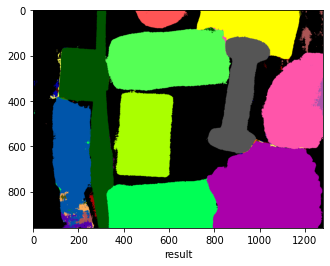

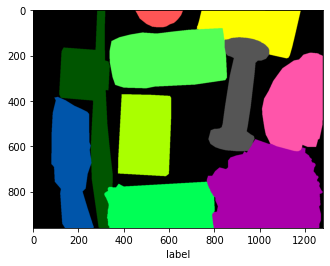

In [ ]:
import matplotlib.pyplot as plt

load_path = "/content/drive/My Drive/ARCdataset_png/checkpoint.pth.tar"

checkpoint = torch.load(load_path)

#print(checkpoint['state_dict'])
model.load_state_dict(checkpoint['state_dict'])


model.cuda()
# ネットワークを評価モードへ変更
model.eval()

# 評価の実行
count = 0
with torch.no_grad():
    for sample in val_loader:
        image, label = sample['image'], sample['label']

        if use_cuda:
            image = image.cuda()
           
        y = model(image)

        pred = y.data.cpu().numpy()
        #label = label.cpu().numpy()
        pred = np.argmax(pred, axis=1)

        result_img = np.transpose(pred, axes=[1, 2, 0])
        label =  np.transpose(label, axes=[1, 2, 0])

        result_img = np.array(result_img).astype(np.uint8)
        label = np.array(label).astype(np.uint8)

        #print(label)

        result_img = cv2.cvtColor(result_img, cv2.COLOR_GRAY2BGR)
        label = cv2.cvtColor(label, cv2.COLOR_GRAY2BGR)

        for i in range(0, class_color.shape[0]):
            #print(i)
            result_img[np.where((result_img ==  [i, i, i]).all(axis=2))] = class_color[i]
            label[np.where((label ==  [i, i, i]).all(axis=2))] = class_color[i]
        
        result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
        label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)

        plt.imshow(result_img)
        plt.xlabel("result")
        plt.show()
        plt.imshow(label)
        plt.xlabel("label")
        plt.show()

        break

img_size = image.size()
#print("test accuracy: {}".format(count.item() / (len(val_loader)*img_size[2]*img_size[3]*batch_size)))